# Notes
* 7 speakers
    * 'cc','cl', 'gg', 'jg', 'mf', 'mk', 'mm'
* 15 emotions
    * 'anxiety', 'boredom', 'cold-anger', 'contempt', 'despair', 'disgust', 'elation', 'happy', 'hot-anger', 'interest', 'neutral', 'panic', 'pride', 'sadness', 'shame'
    

# Feature Extraction

In [40]:
import os
from tqdm import tqdm
import pandas as pd
import parselmouth as pm
from parselmouth.praat import call
import numpy as np

In [41]:
#Function to load only the sounds from directory
def get_sounds(directory):
    samples = [f for f in os.listdir(directory) if f.endswith('.wav')]
    sounds = {os.path.splitext(f)[0]: pm.Sound(os.path.join(directory, f))
          for f in tqdm(samples, desc="Loading sounds")}
    return sounds

In [42]:
directory='hw3_speech_files'
sounds=get_sounds(directory)

Loading sounds: 100%|█████████████████████| 2324/2324 [00:01<00:00, 1678.85it/s]


In [341]:
cols= "speaker_session_emotion_start-time_content".split("_")
pitches=['min_pitch', 'max_pitch', 'mean_pitch']
intensities=['min_intensity', 'max_intensity', 'mean_intensity']
cols.extend(pitches)
cols.extend(intensities)

In [340]:
s=len(sounds)
feature_data=pd.DataFrame(columns=cols)
names=list(sounds.keys())
for i in range(len(names)):
    names[i]=names[i].split("_")
wavs=list(sounds.values())
feature_data

,speaker,session,emotion,start-time,content,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity


In [378]:
#Extract features for each segment in sounds
def get_speech_features(sounds, raw):
    s=len(sounds)
    feature_data=pd.DataFrame(columns=cols)
    names=list(sounds.keys())

    for i in range(len(names)):
        names[i]=names[i].split("_")
    wavs=list(sounds.values())
    for i in tqdm(range(0, s), desc="Extracting Features"):
        sound=wavs[i]
        #extract left channel
        sound = call(sound, "Extract one channel...", 1)
        curr_name=names[i].copy()
        
        if raw==True:
            features=extract_features(curr_name, sound)
        else:
            feautres=norm(curr_name, sound)
            
        feature_row= curr_name + features
        feature_data.loc[i]=feature_row
    return pd.DataFrame(feature_data)

In [403]:
#need to consider the start time!!
def extract_features(name, sound):
    pitch=None
    data=[]
    #pitches
    try:
        pitch = call(sound, "To Pitch (ac)...", 0.0, 75.0, 15, "off", 0.09, 0.5, 0.055, 0.35, 0.14, 600.0)
        min_pitch= call(pitch, "Get minimum...", 0.0, 0.0, "Hertz", "Parabolic")
        max_pitch = call(pitch, "Get maximum...", 0.0, 0.0, "Hertz", "Parabolic")
        mean_pitch = call(pitch, "Get mean...", 0.0, 0.0, "Hertz")
        data.extend([min_pitch, max_pitch, mean_pitch])
    except pm.PraatError as e:
        print(f"Error calculating pitch for segment {name}: {e}")

    #intensities
    try:
        intensity = call(sound, "To Intensity...", 100.0, 0.0, "yes")
        min_intensity = call(intensity, "Get minimum...", 0.0, 0.0, "Parabolic")
        max_intensity = call(intensity, "Get maximum...", 0.0, 0.0, "Parabolic")
        mean_intensity= call(intensity, "Get mean...", 0.0, 0.0, "Energy")
        data.extend([min_intensity, max_intensity, mean_intensity])
    except pm.PraatError as e:
        print(f"Error calculating intensity for segment {name}: {e}")
    return data

In [404]:
raw_feats=get_speech_features(sounds, True)

Extracting Features: 100%|█████████████████| 2324/2324 [00:06<00:00, 361.64it/s]


In [381]:
raw_feats

,speaker,session,emotion,start-time,content,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
0,mf,001,interest,2590.84,Eight-hundred-two,142.941447,396.820777,309.444562,33.579449,69.733383,62.944835
1,mf,001,anxiety,1171.28,Six-hundred-one,146.878081,240.369124,165.253896,42.312602,73.748256,68.540740
2,cc,001,pride,2501.34,March-twenty-fifth,96.296337,141.419203,119.037901,17.928240,64.273383,55.487919
3,cc,001,boredom,2278.62,Six-hundred-six,88.463913,218.533760,134.470845,19.371801,67.532694,60.603199
4,jg,001,panic,443.70,Fifty-seven,145.950479,223.525518,178.398378,26.520651,63.370288,51.328006
...,...,...,...,...,...,...,...,...,...,...,...
2319,cl,001,despair,633.40,Four-hundred-five,81.987731,118.327075,104.279591,19.600579,77.074832,67.756763
2320,cl,001,anxiety,328.81,October-ninth,79.122185,132.417603,96.439813,17.338675,74.458662,64.353252
2321,mf,001,happy,2375.76,November-tenth,226.536911,413.283472,350.822117,36.552680,92.676412,84.349832
2322,cc,001,shame,2411.09,Five-thousand-ten,115.410848,155.934291,132.666293,22.592141,71.225344,64.186652


In [356]:
def agg(sounds, feature):
    speakers= ['cc','cl', 'gg', 'jg', 'mf', 'mk', 'mm']
    speaker_dict = {speaker: [] for speaker in speakers}
    print(speaker_dict)
    s=len(sounds)
    names=list(sounds.keys())
    
    for i in range(len(names)):
        names[i]=names[i].split("_")
    wavs=list(sounds.values())
    for i in tqdm(range(0, s), desc="Extracting Features"):
        sound=wavs[i]
        #extract left channel
        sound = call(sound, "Extract one channel...", 1)
        
        curr_name=names[i].copy()
        speaker=curr_name[0]
        if feature == 'p':
            pitch = call(sound, "To Pitch (ac)...", 0.0, 75.0, 15, "off", 0.09, 0.5, 0.055, 0.35, 0.14, 600.0)
            pitch_array = pitch.selected_array["frequency"]

            speaker_dict[speaker].extend(pitch_array)
            
        elif feature== 'i':
            intensity = call(sound, "To Intensity...", 100.0, 0.0, "yes")
            it_array = intensity.values[0]
            speaker_dict[speaker].extend(it_array)

    return speaker_dict

In [357]:
aggp=agg(sounds, 'p')
speakers= ['cc','cl', 'gg', 'jg', 'mf', 'mk', 'mm']

meta_datap= {speaker: [0,0] for speaker in speakers}
for speaker in list(aggp.keys()):
    meta_datap[speaker][0]=(np.mean(aggp[speaker]))
    meta_datap[speaker][1]=(np.std(aggp[speaker]))

{'cc': [], 'cl': [], 'gg': [], 'jg': [], 'mf': [], 'mk': [], 'mm': []}


Extracting Features: 100%|█████████████████| 2324/2324 [00:03<00:00, 612.05it/s]


In [358]:
meta_datap

{'cc': [57.39317574306563, 98.49721996623948],
 'cl': [38.75709126835308, 80.87979141083703],
 'gg': [121.13157361190865, 147.38267870824848],
 'jg': [88.1646913562374, 132.70978668561088],
 'mf': [93.22934053391651, 112.34504172917977],
 'mk': [112.84049711736914, 158.1991466761],
 'mm': [84.99146333656587, 123.04470135414984]}

In [359]:
aggi=agg(sounds, 'i')
speakers= ['cc','cl', 'gg', 'jg', 'mf', 'mk', 'mm']

meta_datai= {speaker: [0,0] for speaker in speakers}
for speaker in list(aggi.keys()):
    meta_datai[speaker][0]=(np.mean(aggi[speaker]))
    meta_datai[speaker][1]=(np.std(aggi[speaker]))

{'cc': [], 'cl': [], 'gg': [], 'jg': [], 'mf': [], 'mk': [], 'mm': []}


Extracting Features: 100%|████████████████| 2324/2324 [00:01<00:00, 1883.99it/s]


In [386]:
meta_datai

{'cc': [55.23997523150154, 15.837422005298883],
 'cl': [48.43558612642008, 19.78880318546019],
 'gg': [63.74445211738601, 12.931551833545253],
 'jg': [51.56306471740475, 13.566806273296702],
 'mf': [62.873442907784664, 13.24004950433765],
 'mk': [56.603354286197785, 14.549396317711276],
 'mm': [58.976239351627314, 14.230828154304296]}

In [394]:
meta_datap[speaker][1]

123.04470135414984

In [395]:
norm_val= (1 - meta_datap[speaker][0])/meta_datap[speaker][1]
norm_val

-0.6826093477590708

In [414]:
#now that we have the mean and stdev, normalize each array as we get it
def norm(name, sound):
    
    speaker=name[0]
    data=[]
    #now get the pitch/intensity for the current speaker sound
    pitch = call(sound, "To Pitch (ac)...", 0.0, 75.0, 15, "off", 0.09, 0.5, 0.055, 0.35, 0.14, 600.0)
    pitch_array = pitch.selected_array["frequency"]

    #normalize each value in the pitch_array with speaker
    normp=np.array([])
    for val in pitch_array:
        norm_val= (val - meta_datap[speaker][0])/meta_datap[speaker][1]
        normp=np.append(normp, norm_val)
    min_pitch= np.min(normp)
    max_pitch = np.max(normp)
    mean_pitch = np.mean(normp)
    data.extend([min_pitch, max_pitch, mean_pitch])

    #normalize each value in the pitch_array with speaker
    intensity = call(sound, "To Intensity...", 100.0, 0.0, "yes")
    it_array = intensity.values[0]
    normi=np.array([])
    for val in it_array:
        norm_val= (val - meta_datai[speaker][0])/meta_datai[speaker][1]
        normi=np.append(normi, norm_val)
    min_intensity= np.min(normi)
    max_intensity = np.max(normi)
    mean_intensity= np.mean(normi)
    data.extend([min_intensity, max_intensity, mean_intensity])
        
    return data#pd.DataFrame(feature_data)

In [415]:
norm_feats=get_speech_features(sounds, False)

Extracting Features: 100%|█████████████████| 2324/2324 [00:07<00:00, 324.88it/s]


In [416]:
norm_feats

,speaker,session,emotion,start-time,content,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
0,mf,001,interest,2590.84,Eight-hundred-two,-0.829848,2.702313,0.532861,-2.212501,0.517755,-0.507050
1,mf,001,anxiety,1171.28,Six-hundred-one,-0.829848,1.307385,-0.094373,-1.552928,0.817286,0.150264
2,cc,001,pride,2501.34,March-twenty-fifth,-0.582688,0.853079,-0.312820,-2.355922,0.570227,-0.470557
3,cc,001,boredom,2278.62,Six-hundred-six,-0.582688,1.635991,-0.414373,-2.264380,0.757762,-0.143006
4,jg,001,panic,443.70,Fifty-seven,-0.664342,1.019976,-0.389136,-1.845859,0.870182,-0.727404
...,...,...,...,...,...,...,...,...,...,...,...
2319,cl,001,despair,633.40,Four-hundred-five,-0.479194,0.983700,-0.138105,-1.456121,1.446998,0.108894
2320,cl,001,anxiety,328.81,October-ninth,-0.479194,1.158021,-0.247341,-1.568109,1.313029,-0.018427
2321,mf,001,happy,2375.76,November-tenth,-0.829848,2.847567,1.008527,-1.941236,2.250648,0.959124
2322,cc,001,shame,2411.09,Five-thousand-ten,-0.582688,1.000446,-0.220496,-2.059585,1.009341,-0.096420


In [486]:
norm_feats.to_csv("part1_features.csv")

# Now Plot each emotion and each feature using error bars

In [474]:
import matplotlib.pyplot as plt

def plot_feature(feature, raw):
    # Group by emotion and calculate statistics
    name=feature.columns[1]
    grouped = feature.groupby("emotion")[f"{name}"]
    means = grouped.mean()
    std_devs = grouped.std()

    # Sort emotions alphabetically
    emotions = means.index
    mean_values = means.values
    std_values = std_devs.values

    plt.figure(figsize=(12, 6))
    plt.errorbar(emotions, mean_values, yerr=std_values, fmt='o', ecolor='black', capsize=5, label='Mean ± Std Dev')

    plt.xlabel("Emotion")
    plt.ylabel(f"{name}")
    if raw==True:
        plt.title(f"UnNormalized {name} by Emotion")
    else:
        plt.title(f"Normalized {name} by Emotion")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    return plt

## Min_Pitch

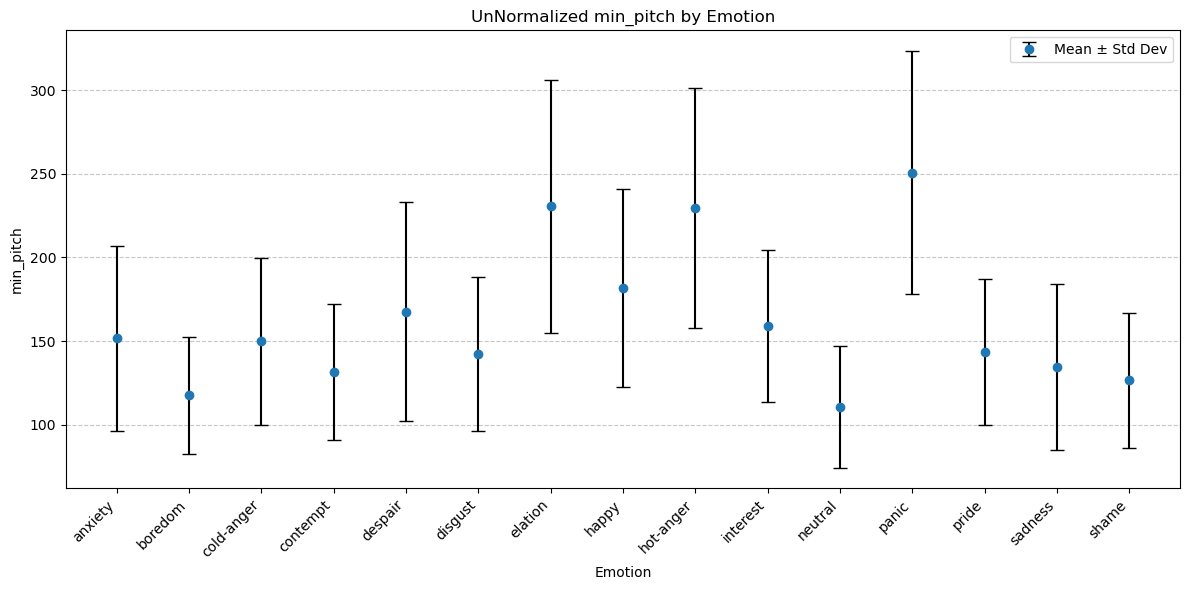

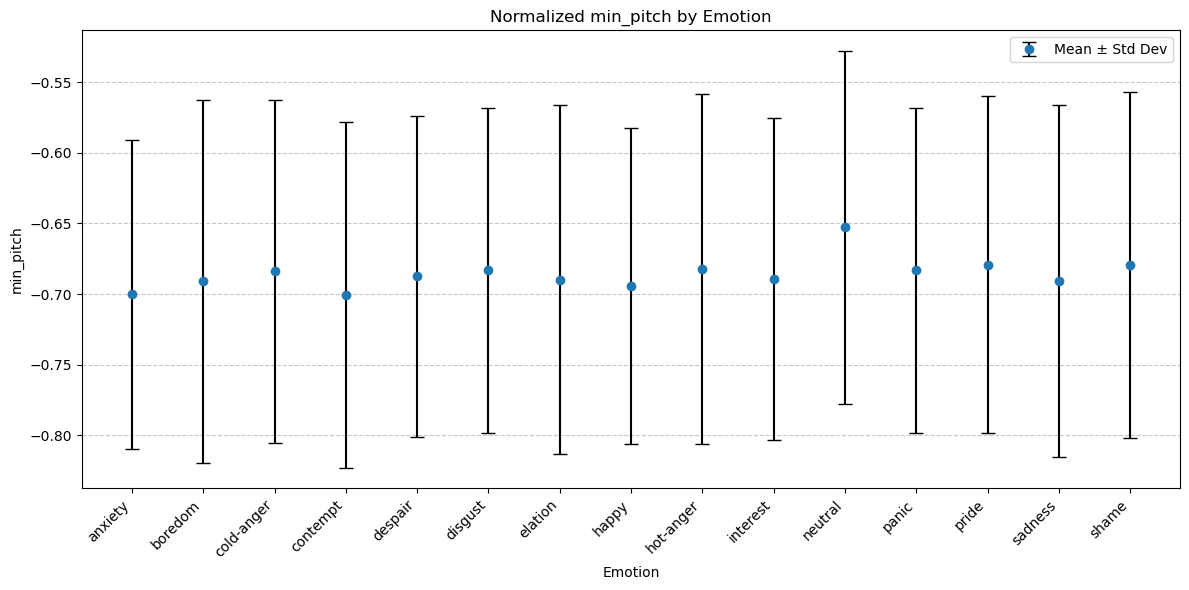

In [475]:
#UnNormalized:
min_pitch= raw_feats[["emotion", "min_pitch"]]
min_plot= plot_feature(min_pitch, True)
min_plot.show()

#Normalized
min_pitch= norm_feats[["emotion", "min_pitch"]]
min_plot= plot_feature(min_pitch, False)
min_plot.show()

## Max_Pitch

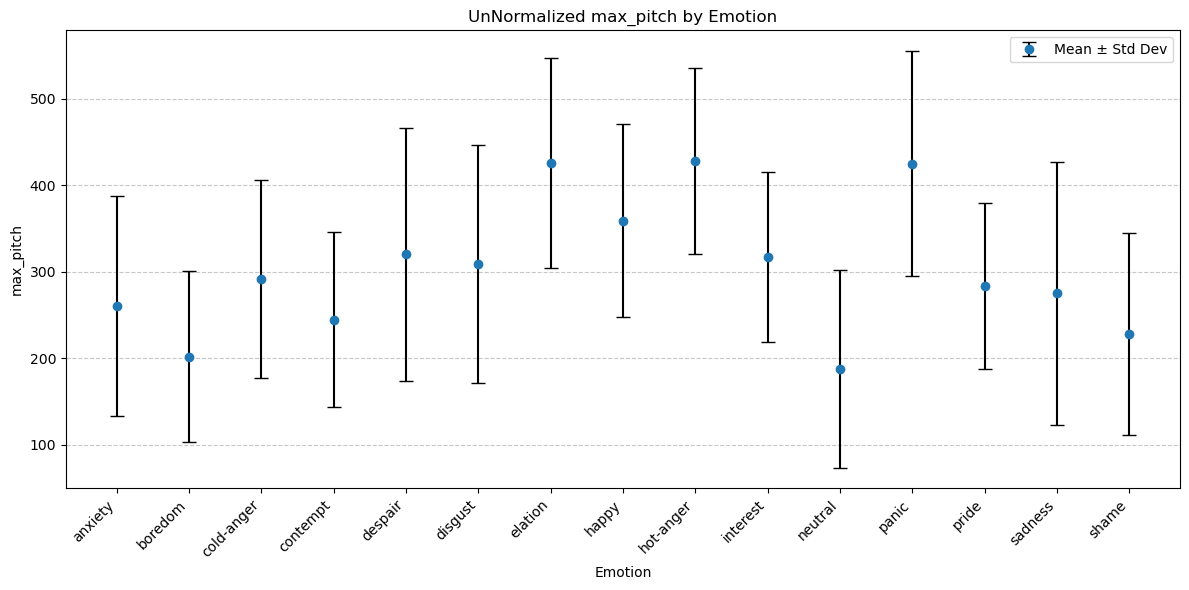

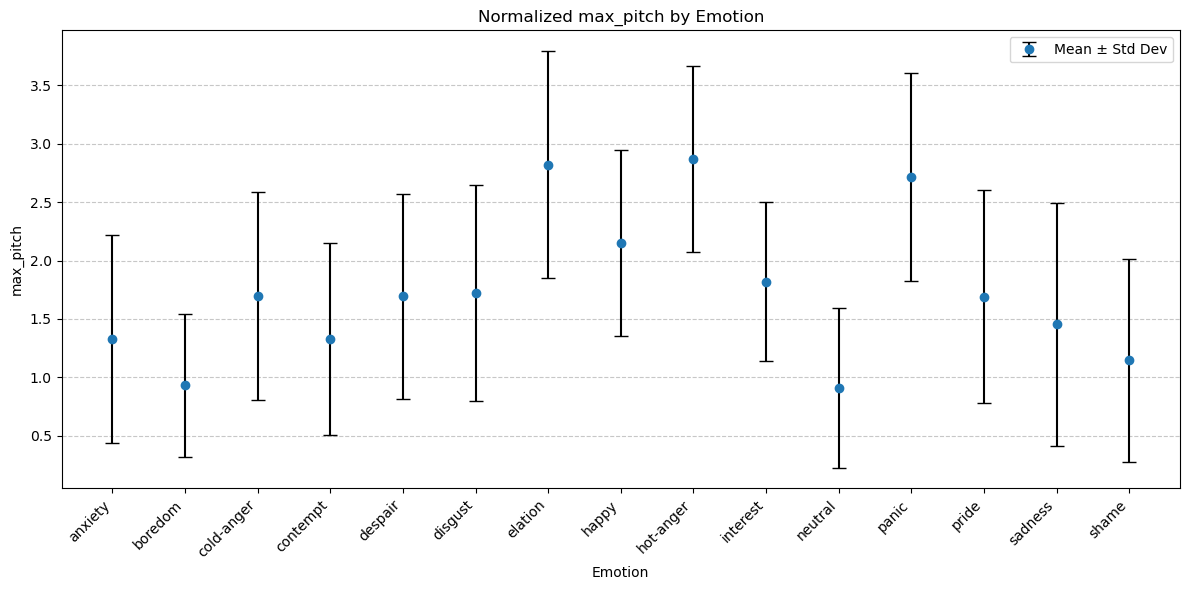

In [476]:
#UnNormalized:
max_pitch= raw_feats[["emotion", "max_pitch"]]
max_plot= plot_feature(max_pitch, True)
max_plot.show()

#Normalized
max_pitch= norm_feats[["emotion", "max_pitch"]]
max_plot= plot_feature(max_pitch, False)
max_plot.show()

## Mean_Pitch

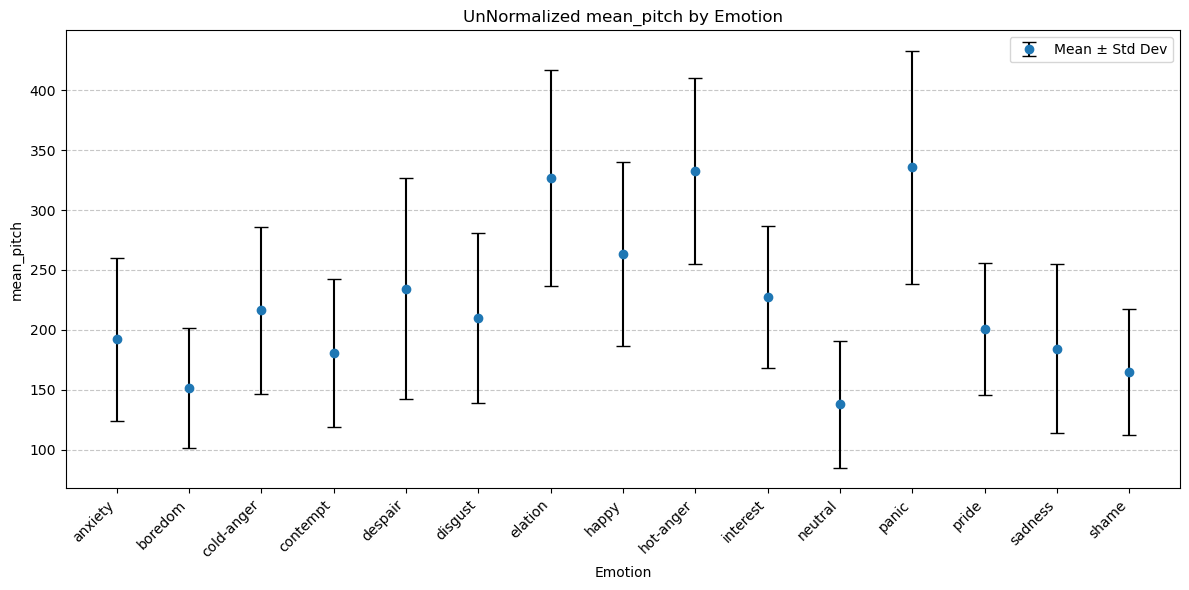

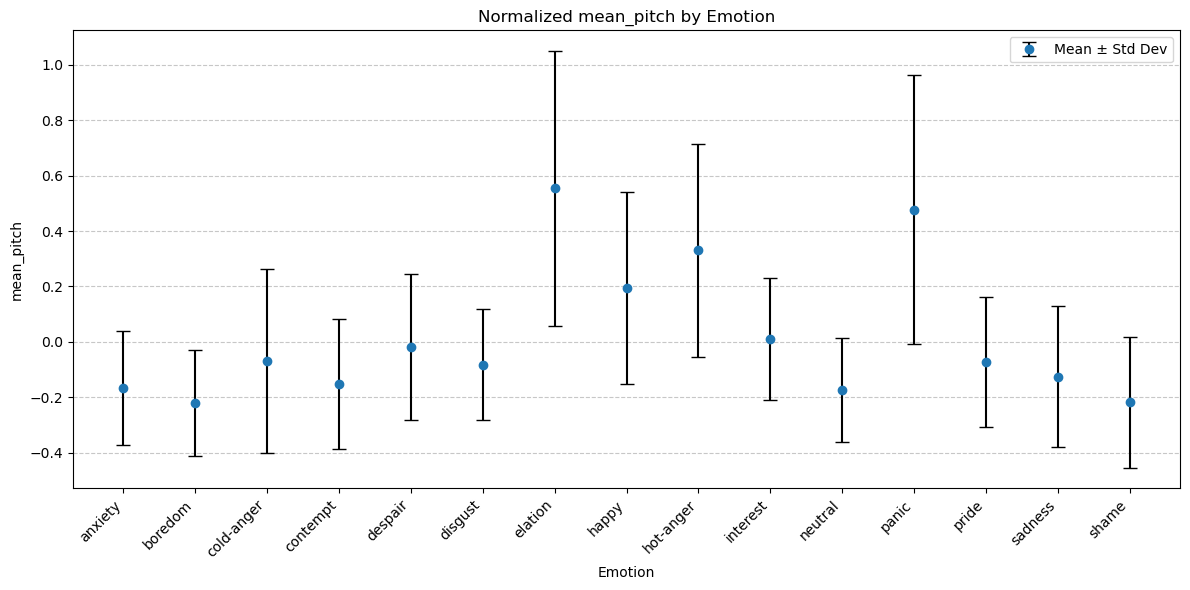

In [477]:
#UnNormalized:
mean_pitch= raw_feats[["emotion", "mean_pitch"]]
mean_plot= plot_feature(mean_pitch, True)
mean_plot.show()

#Normalized
mean_pitch= norm_feats[["emotion", "mean_pitch"]]
mean_plot= plot_feature(mean_pitch, False)
mean_plot.show()

## Min_Intensity

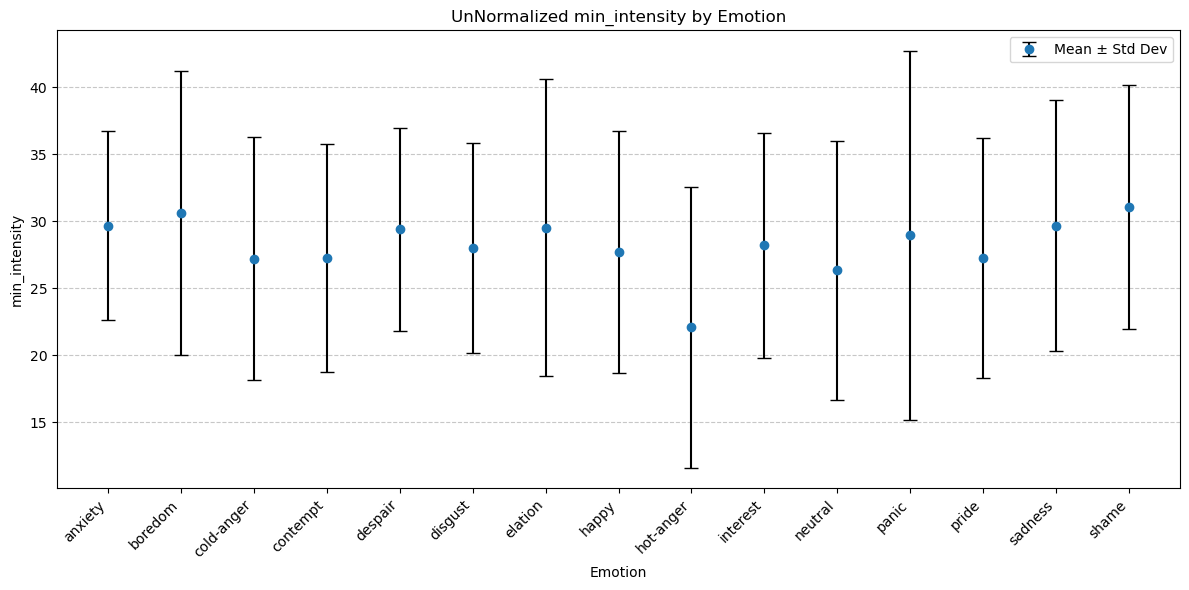

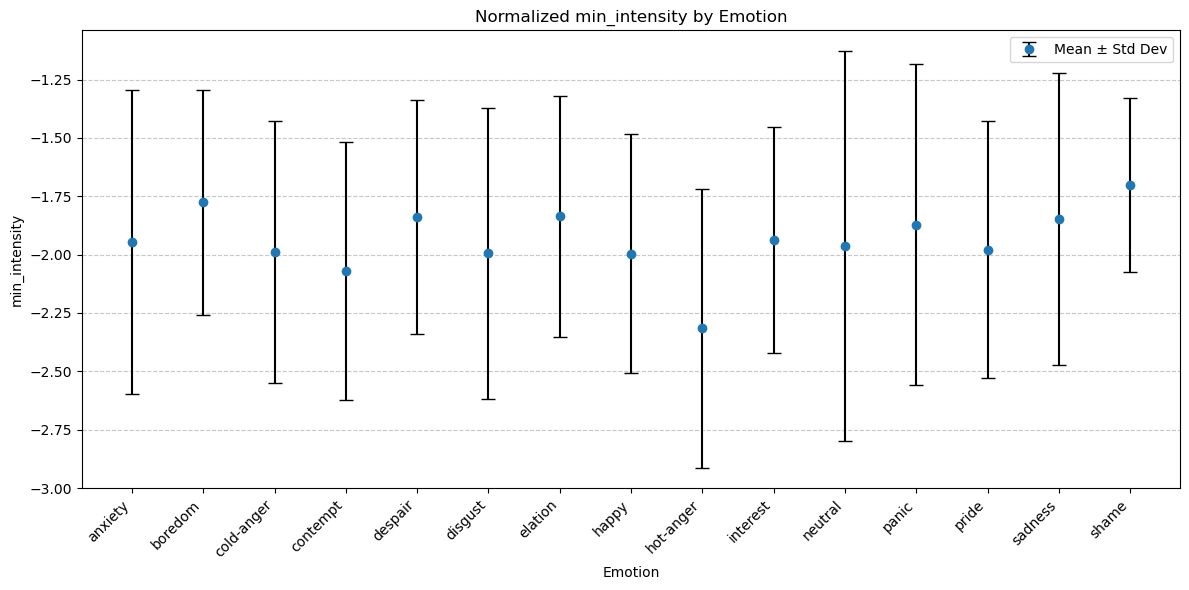

In [478]:
#UnNormalized:
min_intensity= raw_feats[["emotion", "min_intensity"]]
min_plot= plot_feature(min_intensity, True)
min_plot.show()

#Normalized
min_intensity= norm_feats[["emotion", "min_intensity"]]
min_plot= plot_feature(min_intensity, False)
min_plot.show()

## Max_Intensity

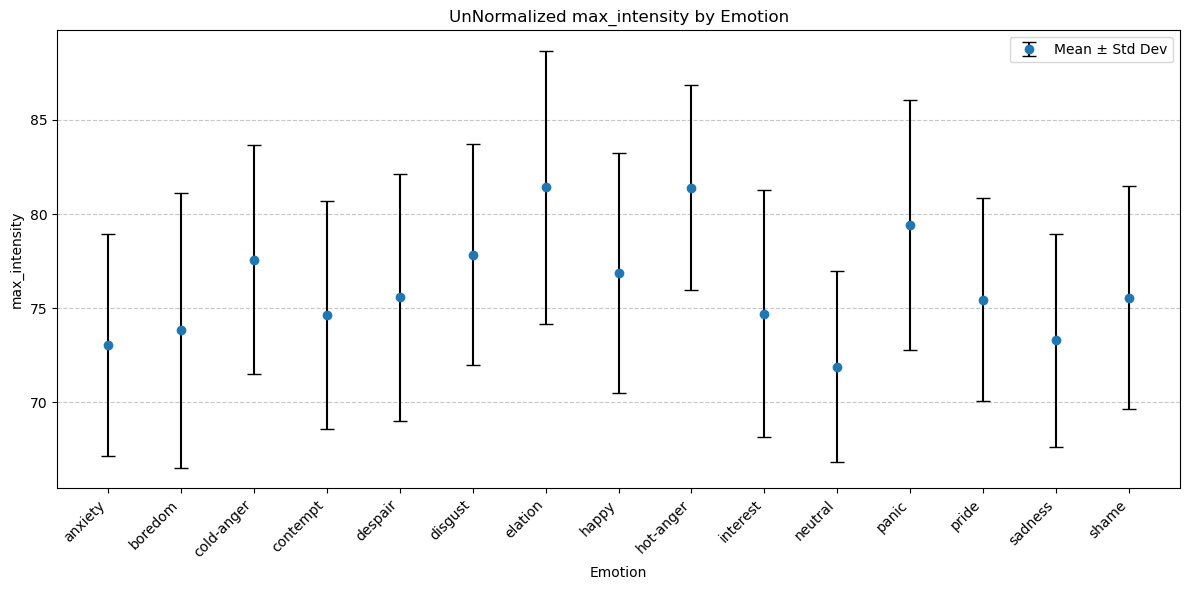

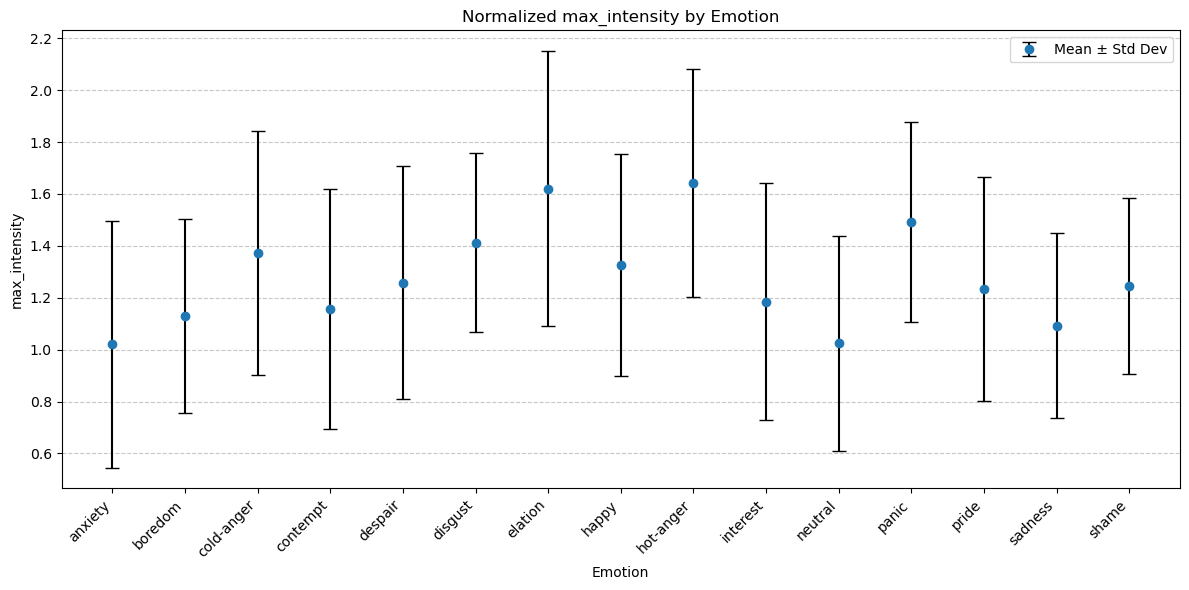

In [479]:
#UnNormalized:
max_intensity= raw_feats[["emotion", "max_intensity"]]
max_plot= plot_feature(max_intensity, True)
max_plot.show()

#Normalized
max_intensity= norm_feats[["emotion", "max_intensity"]]
max_plot= plot_feature(max_intensity, False)
max_plot.show()

## Mean_Intensity

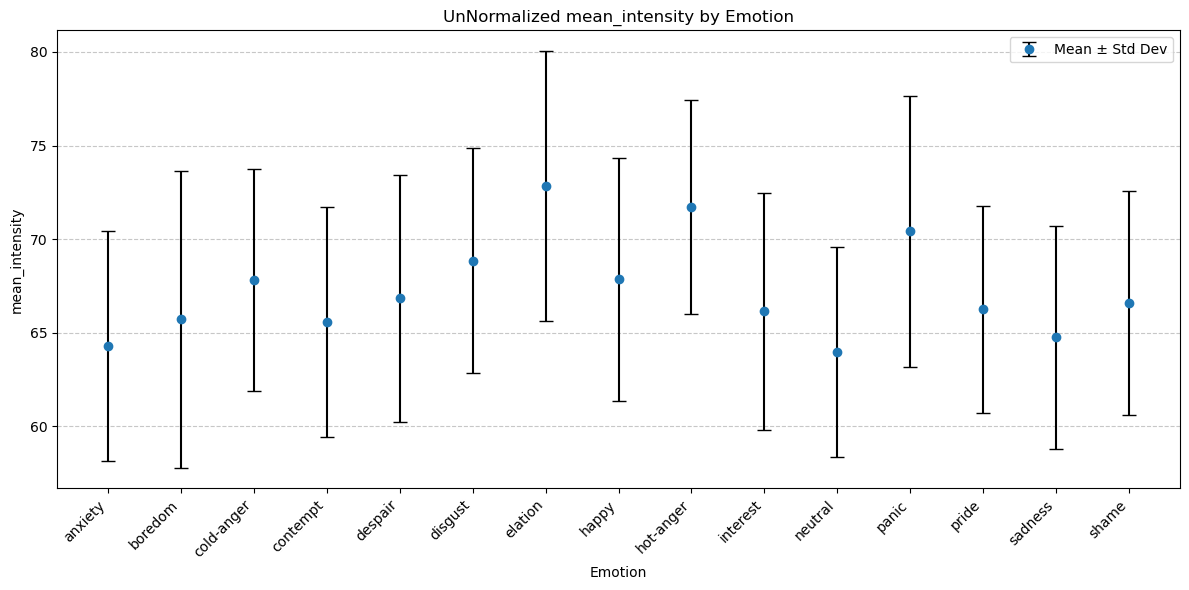

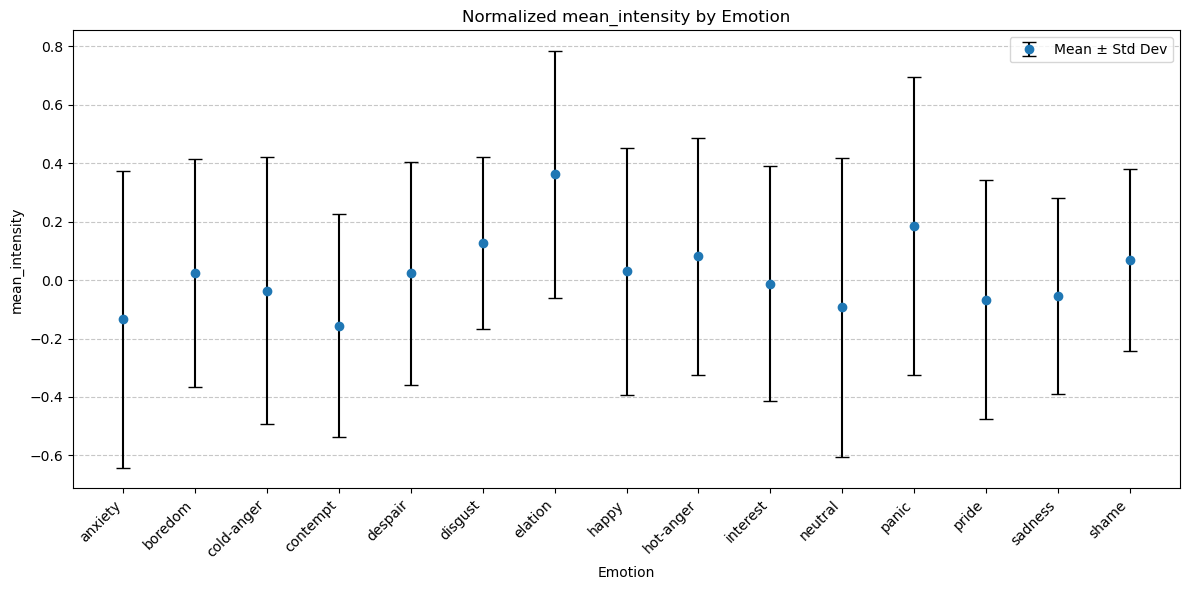

In [481]:
#UnNormalized:
mean_intensity= raw_feats[["emotion", "mean_intensity"]]
mean_plot= plot_feature(mean_intensity, True)
mean_plot.show()

#Normalized
mean_intensity= norm_feats[["emotion", "mean_intensity"]]
mean_plot= plot_feature(mean_intensity, False)
mean_plot.show()